### 重点：1、把年龄，费用按等频率切分
### 2、因为年龄要切分，所以年龄的缺失值填补很重要，利用Name字段进行填补，费用直接用均值就好
### 3、PClass, Sex直接离散化就好
### 4、最后的所有属性归一化
### 5、添加一个family属性 即兄弟姐妹+你+父母+爱人
### 6、添加一个家庭存活情况

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#导入必要的包
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV

D:\ANACONDA\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ANACONDA\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#常用模型
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier #KNN

In [212]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [213]:
data_df = train_df.append(test_df)

In [5]:
data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [214]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
# data_df.drop('Title', axis = 1, inplace = True)

In [215]:
data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp'] + 1

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]

In [121]:
data_df.loc[(data_df.Family_Size == 1) & (data_df.Survived == 0),'Family_Size'].value_counts()
print (train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


In [216]:
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)  #将费用等频率分组
data_df['CategoricalFare'] = pd.qcut(data_df['Fare'], 5)

In [207]:
train_df = data_df[:891]
print (train_df[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

     CategoricalFare  Survived
0    (-0.001, 7.896]  0.197309
1    (7.896, 14.454]  0.303571
2   (14.454, 31.275]  0.441048
3  (31.275, 512.329]  0.600000


In [217]:
data_df['CategoricalAge'] = pd.qcut(data_df['Age'], 4)   #将年龄分组

In [211]:
train_df = data_df[:891]
print (train_df[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (0.169, 19.0]  0.481707
1   (19.0, 25.0]  0.328467
2   (25.0, 31.0]  0.393701
3   (31.0, 42.0]  0.439490
4   (42.0, 80.0]  0.364341


In [38]:
train_df = data_df[:891]
print (train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0      Dr  0.428571
1  Master  0.575000
2    Miss  0.704301
3      Mr  0.160000
4     Mrs  0.795276
5     Rev  0.000000


In [43]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x : x.split(',')[0])
fare_df = data_df.loc[data_df['Family_Size']>1, ["Last_Name", "Fare", "Family_Size"]].iloc[:891]

In [62]:
train_temp_df = data_df[:891]
family_df_grpby = train_temp_df[train_temp_df['Family_Size']>1][\
    ['Last_Name', 'Fare', 'Family_Size', 'Survived']].groupby(['Last_Name', 'Fare'])
family_df = pd.DataFrame(data=family_df_grpby.size(), columns=['Size in train'])

In [218]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x : x.split(',')[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):#grp是后面的group_by的内容，grp_df是所有的内容
    
    if (len(grp_df) != 1):
        # 找到家庭了
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [219]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


In [220]:
data_df.drop(['Embarked', 'Cabin', 'Name', 'Parch', 'PassengerId', 'SibSp', 'Ticket', 'Title', 'Last_Name'], axis = 1, inplace = True)

In [163]:
data_df.head(10)

,Pclass,Sex,Survived,Family_Size,Family_Survival,AgeBin_Code,FareBin_Code
0,3,0,0.0,1,0.5,0,0
1,1,1,1.0,1,0.5,3,4
2,3,1,1.0,0,0.5,1,1
3,1,1,1.0,1,0.0,2,4
4,3,0,0.0,0,0.5,2,1
5,3,0,0.0,0,0.5,1,1
6,1,0,0.0,0,0.5,3,4
7,3,0,0.0,4,0.0,0,2
8,3,1,1.0,2,1.0,1,2
9,2,1,1.0,1,0.0,0,3


In [221]:
label = preprocessing.LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['CategoricalAge'])
data_df.drop('CategoricalAge',1,inplace=True)

label = preprocessing.LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['CategoricalFare'])
data_df.drop('CategoricalFare',1,inplace=True)

data_df['Sex'].replace(['male','female'],[0,1],inplace=True)

data_df.drop(['Age', 'Fare'], axis = 1, inplace = True)

In [222]:
train_df = data_df[:891]
test_df = data_df[891:]

In [225]:
train_df.head()

,Pclass,Sex,Survived,Family_Size,Family_Survival,AgeBin_Code,FareBin_Code
0,3,0,0.0,2,0.5,0,0
1,1,1,1.0,2,0.5,3,4
2,3,1,1.0,1,0.5,1,1
3,1,1,1.0,2,0.0,2,4
4,3,0,0.0,1,0.5,2,1


In [223]:
X = train_df.drop('Survived', 1)
y = train_df['Survived']
test_df.drop('Survived',1,inplace = True) #copy()?深复制吗
X_test = test_df

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [224]:
std_scaler = preprocessing.StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

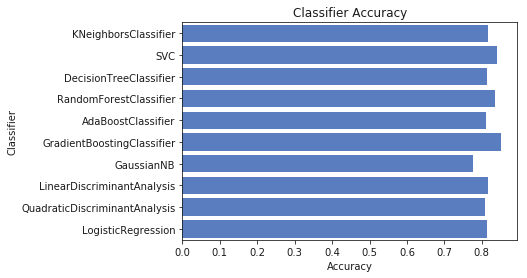

In [173]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)


acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [226]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "accuracy")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0.8462401795735129
KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=22, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    7.6s finished


In [227]:
param_test4 = {
#     'n_estimators':[400,500,1000,1500,2000,3000,3500]
    #'n_estimators':[350,400,450,500],
#     'max_depth':list(range(1,10,2)),
#     'min_child_weight':list(range(1,6,2)),
#     'max_depth':[3,4,5,6],
    #'min_child_weight':[2,3,4],
#     'reg_alpha':[0.01,0.1, 0.5, 1],
#     'gamma':[0.0,0.1,0.2]
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)]
    #'subsample':[0.85,0.9,0.95],
    #'colsample_bytree':[0.75,0.8,0.85]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=1500, max_depth=3,reg_alpha=1,
                                        min_child_weight=5, gamma=0.2, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27), 
                       param_grid = param_test4, scoring='accuracy',n_jobs=1,iid=False, cv=5)
gsearch1.fit(X,y)

gsearch1.best_params_, gsearch1.best_score_

({}, 0.846228704508532)

In [231]:
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-4)
param_test3 = {
    'n_estimators':[8,10,12,15],
    'max_samples':[i/10.0 for i in range(1,10)],
    'max_features':[i/10.0 for i in range(2,9)]
}
gsearch1 = GridSearchCV(BaggingClassifier(clf, n_estimators=15, max_samples=0.7, max_features=0.8,\
                                          bootstrap=True, bootstrap_features=False, n_jobs=1), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch1.fit(X,y)

gsearch1.best_params_, gsearch1.best_score_

({'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 15},
 0.8764800181594922)

In [232]:
gsearch1.best_estimator_.fit(X, y)
predict_test = gd.best_estimator_.predict(X_test)

In [233]:
# candidate_classifier = GradientBoostingClassifier()
# candidate_classifier.fit(X, y)
# predict_test = candidate_classifier.predict(X_test)

new_id = pd.read_csv('data/test.csv')

result = pd.DataFrame({'PassengerId':new_id['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式
result.to_csv("pred_label/GBC.csv", index=False)  #

In [234]:
result.Survived.value_counts()

0    275
1    143
Name: Survived, dtype: int64

In [28]:
pd.qcut(np.arange(3), 3)  #等频率分割数组

[(-0.001, 0.667], (0.667, 1.333], (1.333, 2.0]]
Categories (3, interval[float64]): [(-0.001, 0.667] < (0.667, 1.333] < (1.333, 2.0]]